In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [12]:
"""

'Equity Before Minority Interest/Total Equity'
num nan or inf is 64%
"""



"\n\n'Equity Before Minority Interest/Total Equity'\nnum nan or inf is 64%\n"

In [13]:
"""
binary weighted classification vs multiclass classification
method: do 15 pred dates, 12 diff columns, 400 or 500 boosting rounds?, which eval metrics?,  

"""

'\nbinary weighted classification vs multiclass classification\nmethod: do 15 pred dates, 12 diff columns, 400 or 500 boosting rounds?, which eval metrics?,  \n\n'

In [2]:
Date1 = np.load("training_sets/Date1.npy", allow_pickle = True)
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)
Date3 = np.load("training_sets/Date3.npy", allow_pickle = True)

In [3]:
Dates = np.append(np.append(Date1, Date2), Date3)

In [16]:
375 + 235

610

In [4]:
prediction_dates = np.linspace(610, len(Dates) - 100, 5).astype(int)

In [5]:
prediction_dates

array([ 610, 1016, 1423, 1830, 2237])

In [6]:
features1 = pd.read_pickle("training_sets/features1")

In [8]:
columns_to_choose_from = features1.columns[:-3]

In [21]:
cols_trials = []
for i in range(4):
    if i < 1:
        cols_trials.append(np.random.choice(columns_to_choose_from, 6, replace = False))
        
    elif i < 2:
        
        cols_trials.append(np.random.choice(columns_to_choose_from, 14, replace = False))
        
    elif i < 3:
        cols_trials.append(np.random.choice(columns_to_choose_from, 22, replace = False))
    
    else:
        cols_trials.append(np.random.choice(columns_to_choose_from, 30, replace = False))
        

In [9]:
def make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, pred_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)
    
    
    
    X_test = shuffle(df.loc[prediction_period, np.append(np.append(cols, pred_col), "return_40")])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test = X_test.pop(pred_col)
    Y_return_40 = X_test.pop("return_40")
    
    return X_train, X_test, Y_train, Y_test, Y_return_40

In [10]:
def return_40_metric(pred, labels):


    return np.mean(labels[np.argsort(pred[:,0])[::-1][:500]]), np.sort(pred[:,0])[::-1][499], np.mean(labels[np.argsort(pred[:,0])[::-1][:100]]), np.sort(pred[:,0])[::-1][99], np.mean(labels[np.argsort(pred[:,0])[::-1][:20]]), np.sort(pred[:,0])[::-1][19]

In [11]:
class my_callback(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
            
            
        if not epoch %10:

            print(epoch)

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False

In [12]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'multi:softprob',
  'subsample': 0.9,
'num_class' : 2,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [31]:
with open('BinaryVsMulti/results2.pkl', 'wb') as f:
    pickle.dump(results, f)

In [36]:
results_multi = results.copy()

In [13]:
with open("binaryVsMulti/results2.pkl", "rb") as f:
    results_multi = pickle.load(f)

In [14]:
results_multi[0][0][1]

array(['close_320/Close_360', 'close_160/Close_320',
       'Net Income/Enterprise Value_QC', 'Free Cash Flow/Revenue_YC',
       'Book to Market Value', 'volstd_20'], dtype=object)

In [15]:
cols_trials = []
for i in range(len(results_multi[0])):
    cols_trials.append(results_multi[0][i][1])

In [17]:
results_not_deleted = results.copy()

In [18]:
results = []

for indx_num, prediction_date_number in enumerate(prediction_dates):
    

    #if indx_num >0:
        
        #time.sleep(600)
        

    results1 = []

    training_period = Dates[prediction_date_number - 200 - 40 + 1: prediction_date_number - 40 +1]

    prediction_period = Dates[prediction_date_number :prediction_date_number + 20 + 1]
    
    
    for cols in cols_trials:
        
        start_time_df_create = time.perf_counter()
        
        results2 = []
    
        if len(np.intersect1d(np.append(training_period, prediction_period), Date1)):

            if "features1" not in locals():

                features1 = pd.read_pickle("training_sets/features1")   

                print("imported features1")

            Date1_intersect = np.intersect1d(np.append(training_period, prediction_period), Date1)

            #X_train_master = features1.loc[Date1_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])]
            X_train_master = features1.loc[Date1_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])]


        else:

            if "features1" in locals():
                del features1

                print("deleted features1")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date2)):

            if "features2" not in locals():

                features2 = pd.read_pickle("training_sets/features2")

                print("imported features2")

            Date2_intersect = np.intersect1d(np.append(training_period, prediction_period), Date2)

            if "X_train_master" in locals():

                #X_train_master = X_train_master.append(features2.loc[Date2_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])])
                X_train_master = X_train_master.append(features2.loc[Date2_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])])

            else:

                #X_train_master = features2.loc[Date2_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])]
                X_train_master = features2.loc[Date2_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])]
        else:

            if "features2" in locals():
                del features2

                print("deleted features2")


        if len(np.intersect1d(np.append(training_period, prediction_period), Date3)):

            if "features3" not in locals():

                features3 = pd.read_pickle("training_sets/features3")

                print("imported features3")


            Date3_intersect = np.intersect1d(np.append(training_period, prediction_period), Date3)

            if "X_train_master" in locals():

                #X_train_master = X_train_master.append(features3.loc[Date3_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])])
                X_train_master = X_train_master.append(features3.loc[Date3_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])])

            else:

                #X_train_master = features3.loc[Date3_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])]
                X_train_master = features3.loc[Date3_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])]
        else:

            if "features3" in locals():
                del features3

                print("deleted features3")


        print("df_create_time: "+ str(time.perf_counter() - start_time_df_create))
        
        
        
        start_time_train = time.perf_counter()
        

        #X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, "Class_multi_40_20")
        #xgtrain = xgboost.DMatrix(X_train.values, Y_train, feature_names = cols)
        X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, "Class_binary_40_20")
        train_weights = Y_train.map({0:19, 1:1})
        xgtrain = xgboost.DMatrix(X_train.values, Y_train, feature_names = cols, weight = train_weights)
        xgtest = xgboost.DMatrix(X_test.values, Y_test.values, feature_names = cols)
        
        results3 = []
        

        mycallback = my_callback(xgtest, Y_return_40, results3)

        start_time = time.perf_counter()
        bst = xgboost.train(params1, xgtrain, num_boost_round = 400, verbose_eval = False, callbacks = [mycallback])
        
        
        results2.append(Dates[prediction_date_number])
        results2.append(cols)
        results2.append(results3)
        
        results1.append(results2)
        
        print(time.perf_counter() - start_time_train)
        
        del X_train_master
        
        
    results.append(results1)
    
    with open('BinaryVsMulti/results_binary_weighted2.pkl', 'wb') as f:
        pickle.dump(results, f)
        
        
    

imported features1
deleted features2
df_create_time: 1.4027309999999034
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
143.01363460000005
df_create_time: 0.31351789999996527
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
152.46911260000013
df_create_time: 0.32285750000005464
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
160.21734370000013
df_create_time: 0.30714640000019244
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
163.47108619999995
deleted features1
imported features2
df_create_time: 1.5616059999999834
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210

In [21]:
with open('BinaryVsMulti/results_binary.pkl', 'rb') as f:
        results_binary = pickle.load(f)

In [22]:
results_binary_weighted = results.copy()

In [28]:
print("hello")

hello


In [41]:
len(results_multi), len(results)

(5, 5)

In [65]:
training_period = Dates[prediction_date_number - 200 - 40 + 1: prediction_date_number - 40 +1]

prediction_period = Dates[prediction_date_number :prediction_date_number + 20 + 1]
    

if len(np.intersect1d(np.append(training_period, prediction_period), Date1)):

    if "features1" not in locals():

        features1 = pd.read_pickle("training_sets/features1")   

        print("imported features1")

    Date1_intersect = np.intersect1d(np.append(training_period, prediction_period), Date1)

    #X_train_master = features1.loc[Date1_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])]
    X_train_master = features1.loc[Date1_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])]


else:

    if "features1" in locals():
        del features1

        print("deleted features1")


if len(np.intersect1d(np.append(training_period, prediction_period), Date2)):

    if "features2" not in locals():

        features2 = pd.read_pickle("training_sets/features2")

        print("imported features2")

    Date2_intersect = np.intersect1d(np.append(training_period, prediction_period), Date2)

    if "X_train_master" in locals():

        #X_train_master = X_train_master.append(features2.loc[Date2_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])])
        X_train_master = X_train_master.append(features2.loc[Date2_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])])

    else:

        #X_train_master = features2.loc[Date2_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])]
        X_train_master = features2.loc[Date2_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])]
else:

    if "features2" in locals():
        del features2

        print("deleted features2")


if len(np.intersect1d(np.append(training_period, prediction_period), Date3)):

    if "features3" not in locals():

        features3 = pd.read_pickle("training_sets/features3")

        print("imported features3")


    Date3_intersect = np.intersect1d(np.append(training_period, prediction_period), Date3)

    if "X_train_master" in locals():

        #X_train_master = X_train_master.append(features3.loc[Date3_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])])
        X_train_master = X_train_master.append(features3.loc[Date3_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])])

    else:

        #X_train_master = features3.loc[Date3_intersect, np.append(cols, ["Class_multi_40_20", "return_40"])]
        X_train_master = features3.loc[Date3_intersect, np.append(cols, ["Class_binary_40_20", "return_40"])]
else:

    if "features3" in locals():
        del features3

        print("deleted features3")


print("df_create_time: "+ str(time.perf_counter() - start_time_df_create))


#X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, "Class_multi_40_20")

X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(X_train_master, training_period, prediction_period, cols, "Class_binary_40_20")

imported features1
deleted features3
df_create_time: 8170.978776899996


In [67]:
np.mean(Y_return_40)

-2.7380384169441094

In [68]:
sp500 = pd.read_pickle("External_data/sp500")

In [69]:
sp500.loc[Dates[prediction_date_number], "return_40"]

0.21242840624916215

In [ ]:
"""
questions:
obv compare multi and binary
do we see a corr between threshold and return?

"""

In [117]:
pred_date_number = 3
col_number = 2
prediction_date_number = prediction_dates[pred_date_number]
cols = results_multi[pred_date_number][col_number][1]

In [124]:
Dates[prediction_dates]

array(['2014-02-28', '2016-02-16', '2017-09-26', '2019-05-10',
       '2021-04-28'], dtype=object)

In [69]:
np.shape(np.array(results_binary))

<ipython-input-69-40fef1fde0a1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.shape(np.array(results_binary))


(5, 4, 3)

In [86]:
mean_1 = []
for pred_number in range(5):
    for col_number in range(4):
        data = []
        data.append(np.mean(np.array(results_binary[pred_number][col_number][2])[:1,4]))
        data.append(np.mean(np.array(results_binary_weighted[pred_number][col_number][2])[:1,4]))
        
        mean_1.append(data)

In [81]:
mean_5 = []
for pred_number in range(5):
    for col_number in range(4):
        data = []
        data.append(np.mean(np.array(results_binary[pred_number][col_number][2])[:5,4]))
        data.append(np.mean(np.array(results_binary_weighted[pred_number][col_number][2])[:5,4]))
        
        mean_5.append(data)

In [74]:
mean_20 = []
for pred_number in range(5):
    for col_number in range(4):
        data = []
        data.append(np.mean(np.array(results_binary[pred_number][col_number][2])[:20,4]))
        data.append(np.mean(np.array(results_binary_weighted[pred_number][col_number][2])[:20,4]))
        
        mean_20.append(data)
        

In [79]:
mean_50 = []
for pred_number in range(5):
    for col_number in range(4):
        data = []
        data.append(np.mean(np.array(results_binary[pred_number][col_number][2])[:50,4]))
        data.append(np.mean(np.array(results_binary_weighted[pred_number][col_number][2])[:50,4]))
        
        mean_50.append(data)

In [89]:
np.sum(np.array(mean_5)[:,0] > np.array(mean_20)[:,0])

9

In [80]:
np.sum(np.array(mean_20)[:,0] > np.array(mean_20)[:,1])

11

In [78]:
np.sum(np.array(mean_20)[:,0] > np.array(mean_20)[:,1])

11

In [ ]:
np.array(results_binary)[:,]

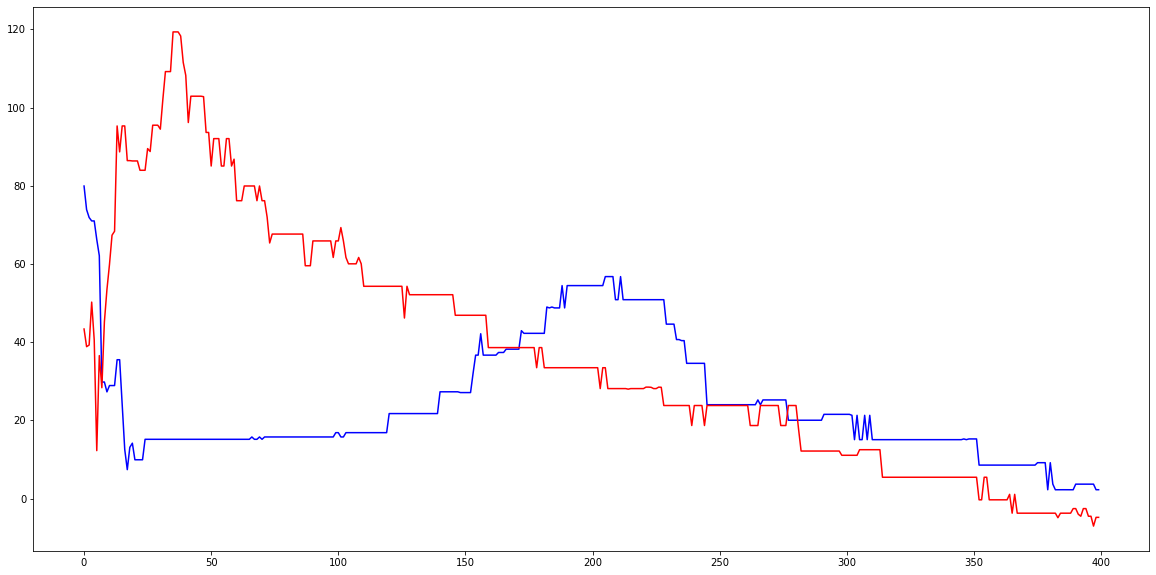

In [67]:
#a = [np.array(results_multi[pred_date_number][3][2])[:,0] for pred_date_number in range(5) for j in range(4)]
#b = [np.array(results[pred_date_number][3][2])[:,0] for pred_date_number in range(5) for j in range(4)]
#a = [np.array(results_binary_weighted[pred_date_number][3][2])[:,4] for pred_date_number in range(5) for j in range(4)]
#b = [np.array(results_binary[pred_date_number][3][2])[:,4] for pred_date_number in range(5) for j in range(4)]

pred_number = 4
col_number = 2

a = np.array(results_binary[pred_number][col_number][2])[:,4]
b = np.array(results_binary_weighted[pred_number][col_number][2])[:,4]

plt.figure(figsize = (20, 10))
plt.plot(a, "b")
plt.plot(b, "r")

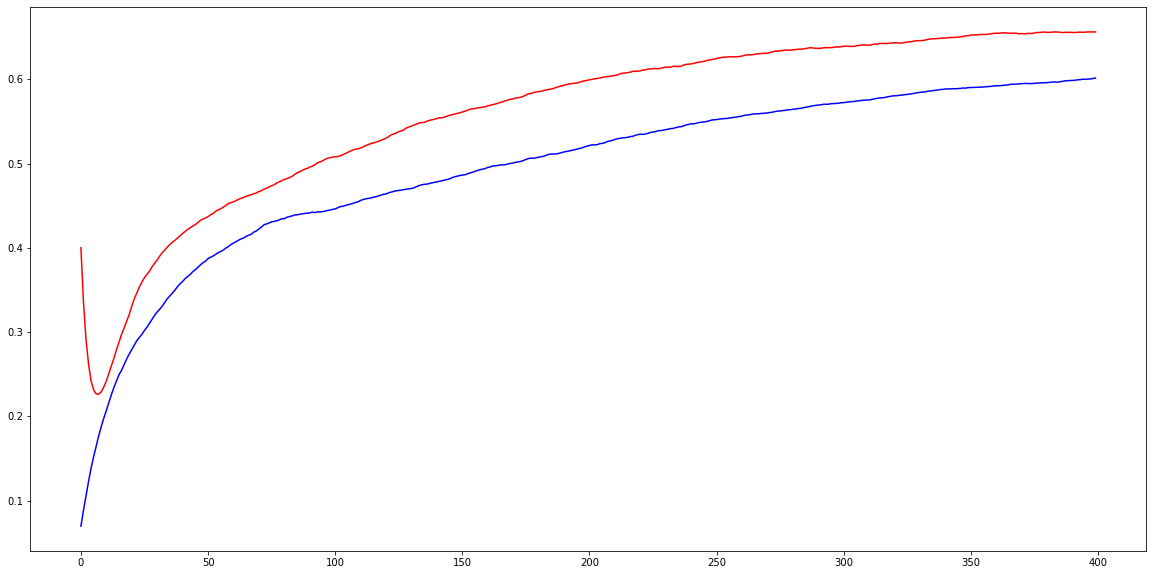

In [119]:
#a = [np.array(results_multi[pred_date_number][j][2])[:,5] for j in range(4)]
#b = [np.array(results[pred_date_number][j][2])[:,5] for j in range(4)]
a = [np.array(results_multi[pred_date_number][0][1])[:,4] for j in range(4)]
b = [np.array(results[pred_date_number][0][1])[:,5] for j in range(4)]

plt.figure(figsize = (20, 10))
plt.plot(np.mean(a, axis = 0), "b")
plt.plot(np.mean(b, axis = 0), "r")

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(np.array(results_multi[pred_date_number][col_number][2])[:,4], "b")
plt.plot(np.array(results[pred_date_number][col_number][2])[:,4], "r")

#plt.plot(np.array(results_multi[pred_date_number][col_number][2])[:,2], "r")
#plt.plot(np.array(results_multi[pred_date_number][col_number][2])[:,0], "g")